In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error
from math import sqrt
from hampel import hampel
import time
from IPython.display import clear_output
import matplotlib.dates as mdates


In [3]:
df = pd.read_csv('medidas_04-05-2021/quarterly_measurements_CPD1.csv')

In [5]:
df['total_consumption'] = df['consumption_peak_time'] + df['consumption_off_peak_time'] + df['generated_energy_off_peak_time'] + df['generated_energy_peak_time']

In [6]:
df['collection_date'] = pd.to_datetime(df['collection_date'], format='%Y-%m-%d %H:%M:%S')


In [7]:
df = df.sort_values('collection_date')

In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
no_outliers_consumption = hampel(df['total_consumption'], window_size=16, n=2, imputation=True)

In [10]:
df['no_outliers_consumption'] = no_outliers_consumption

In [11]:
X = df['no_outliers_consumption'].values
size = int(len(X) * 0.7)
train, test = X[:size], X[size:]
history = [x for x in train]
predictions = list()
a = 0
b = len(train)

time_per_loop = []

for t in range(len(test)):
    start = time.time()
    model = ARIMA(history[a:b], order=(3,0,0))
    model_fit = model.fit(method='innovations_mle')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    end = time.time()
    a += 1
    b += 1
    time_per_loop.append(end-start)

    
    print('%d: predicted=%f, expected=%f' % (t, yhat, obs))
    clear_output(wait=True)

5812: predicted=5638.807895, expected=5632.681885


In [13]:
print(f"Seconds per training loop: {sum(time_per_loop)/len(time_per_loop)} s")
print(f"Total training time: {sum(time_per_loop)} s")

Seconds per training loop: 1.8603958485152334 s
Total training time: 10814.481067419052 s


Test MAE: 89.593


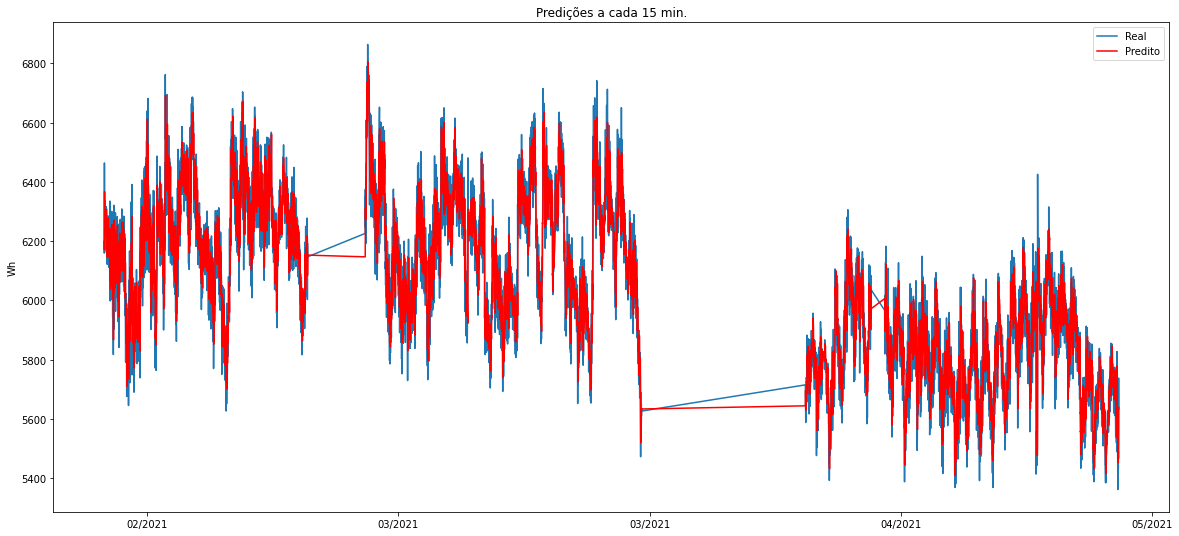

In [16]:
# evaluate forecasts
mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)
# plot forecasts against actual outcomes
plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.gcf().autofmt_xdate()

plt.title('Predições a cada 15 min.')
plt.plot(df[size:].collection_date, test, label='Real')
plt.plot(df[size:].collection_date, predictions, color='red', label='Predito')
plt.legend(loc="upper right")
plt.show()

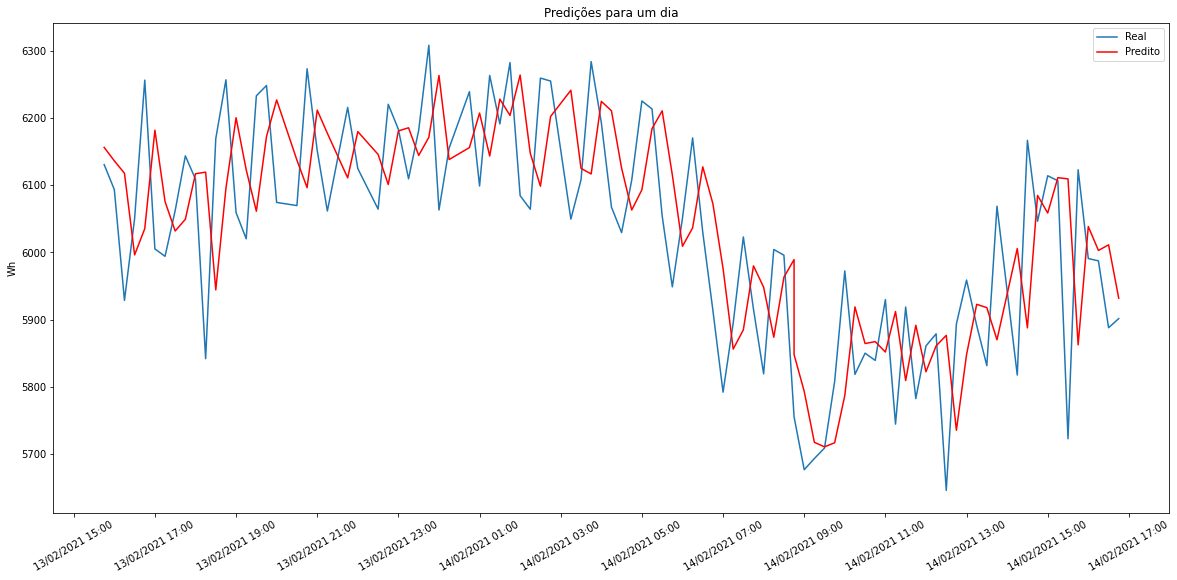

In [43]:
plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 2))
plt.gcf().autofmt_xdate()
plt.title('Predições para um dia')

plt.plot(df[size + 96:size+96+96].collection_date, test[96:96 + 96], label='Real')
plt.plot(df[size + 96:size+96+96].collection_date, predictions[96:96 + 96], color='red', label='Predito')
plt.xticks(rotation=30)
plt.legend(loc="upper right")
plt.show()

# Teste de Ljung-Box

In [35]:
acorr_ljungbox(model_fit.resid, return_df=True)

/home/joaorobson/Documentos/env/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)


,lb_stat,lb_pvalue
1,0.005662,0.940021
2,0.144614,0.930245
3,1.966530,0.579383
4,9.358165,0.052745
5,20.680660,0.000931
6,26.553685,0.000176
7,29.540629,0.000115
8,38.124109,0.000007
9,39.059843,0.000011
10,43.343195,0.000004


In [36]:
X = df['no_outliers_consumption'].values
size = int(len(X) * 0.7)
train, test = X[:size], X[size:]
history = [x for x in train]
predictions_with_diff = list()
a = 0
b = len(train)

time_per_loop_with_diff = []

for t in range(len(test)):
    start = time.time()
    model = ARIMA(history[a:b], order=(3,1,0))
    model_fit_with_diff = model.fit(method='innovations_mle')
    output = model_fit_with_diff.forecast()
    yhat = output[0]
    predictions_with_diff.append(yhat)
    obs = test[t]
    history.append(obs)
    end = time.time()
    a += 1
    b += 1
    time_per_loop_with_diff.append(end-start)

    
    print('%d: predicted=%f, expected=%f' % (t, yhat, obs))
    clear_output(wait=True)

/home/joaorobson/Documentos/env/lib/python3.7/site-packages/statsmodels/tsa/arima/model.py:376: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  ' estimation by method "%s".' % method)


5812: predicted=5624.330042, expected=5632.681885


In [37]:
print(f"Seconds per training loop: {sum(time_per_loop_with_diff)/len(time_per_loop_with_diff)} s")
print(f"Total training time: {sum(time_per_loop_with_diff)} s")

Seconds per training loop: 0.9684542484175168 s
Total training time: 5629.624546051025 s


Test MAE: 89.356


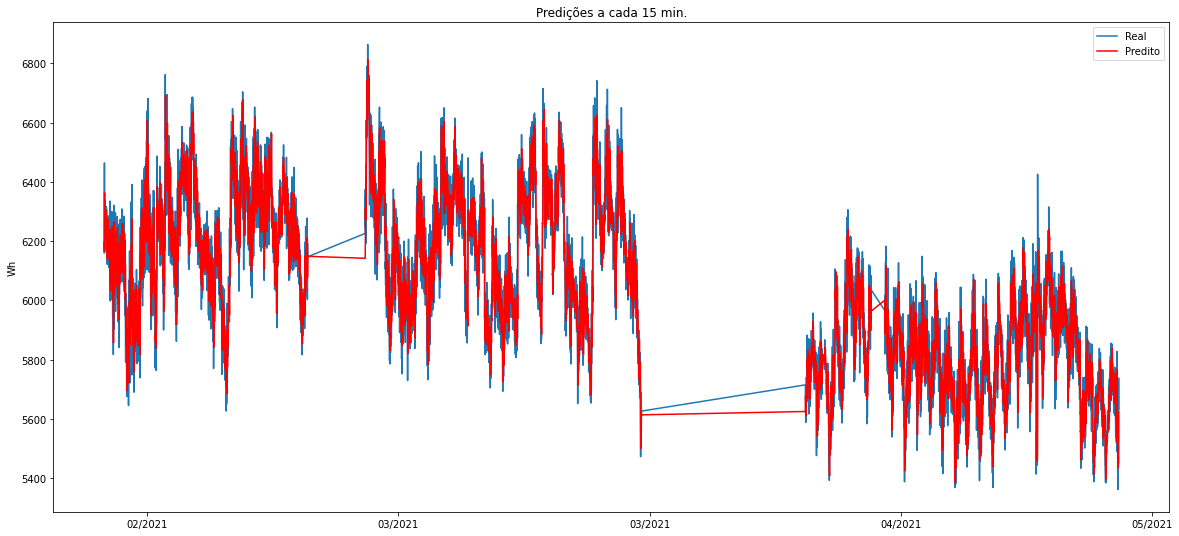

In [38]:
# evaluate forecasts
mae = mean_absolute_error(test, predictions_with_diff)
print('Test MAE: %.3f' % mae)
# plot forecasts against actual outcomes
plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.gcf().autofmt_xdate()

plt.title('Predições a cada 15 min.')
plt.plot(df[size:].collection_date, test, label='Real')
plt.plot(df[size:].collection_date, predictions_with_diff, color='red', label='Predito')
plt.legend(loc="upper right")
plt.show()

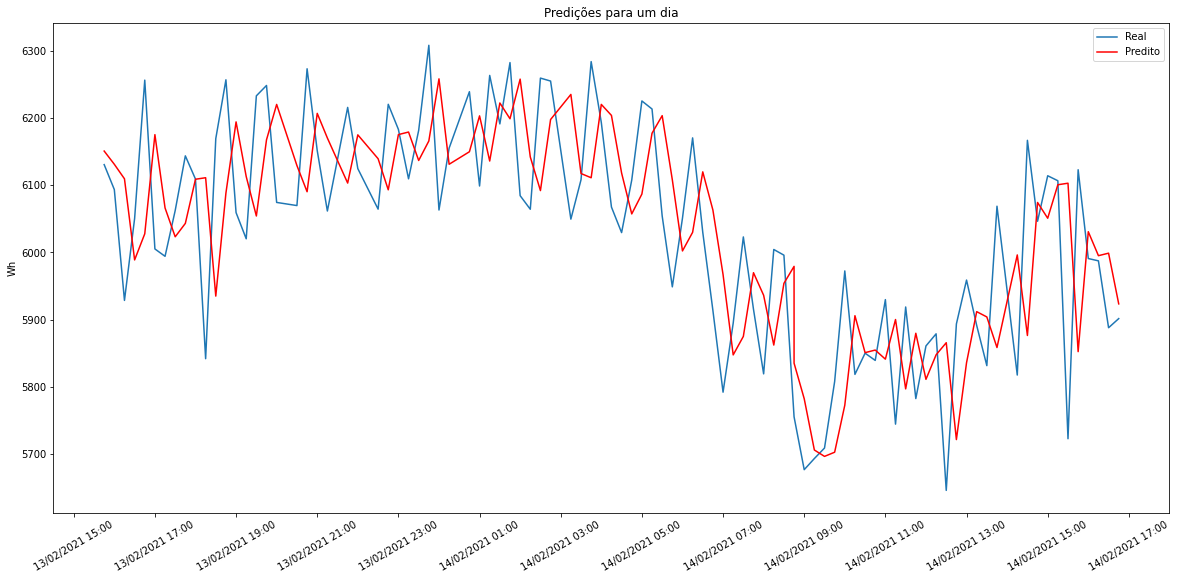

In [45]:
plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 2))
plt.gcf().autofmt_xdate()
plt.title('Predições para um dia')

plt.plot(df[size + 96:size+96+96].collection_date, test[96:96 + 96], label='Real')
plt.plot(df[size + 96:size+96+96].collection_date, predictions_with_diff[96:96 + 96], color='red', label='Predito')
plt.xticks(rotation=30)
plt.legend(loc="upper right")
plt.show()

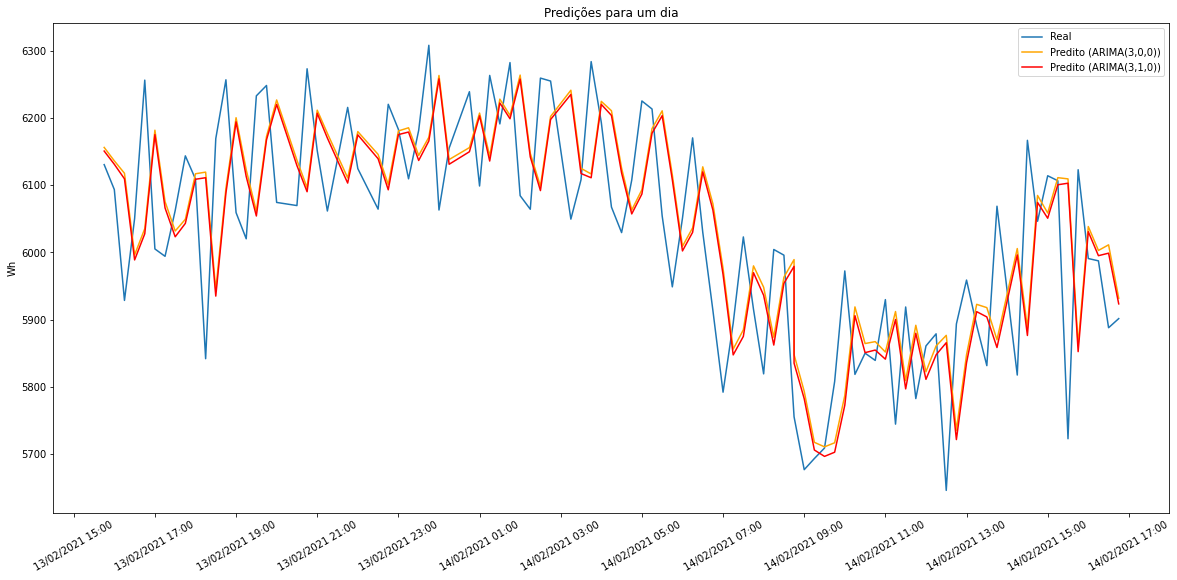

In [48]:
plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 2))
plt.gcf().autofmt_xdate()
plt.title('Predições para um dia')

plt.plot(df[size + 96:size+96+96].collection_date, test[96:96 + 96], label='Real')
plt.plot(df[size + 96:size+96+96].collection_date, predictions[96:96 + 96], color='orange', label='Predito (ARIMA(3,0,0))')
plt.plot(df[size + 96:size+96+96].collection_date, predictions_with_diff[96:96 + 96], color='red', label='Predito (ARIMA(3,1,0))')
plt.xticks(rotation=30)
plt.legend(loc="upper right")
plt.show()